In [95]:
# from custom_module import *
from slfmri import ui as slui
from slfmri import io as slio
from slfmri.lib.errors import SilentIO
from tqdm.notebook import tqdm
import nibabel as nib
import numpy as np
import pynipt as pn

# Prep mask image for analysis
mask_path = '../Template/Rat_CAMRI_400um_MASK_v2-1.nii.gz'
mask_nii = nib.load(mask_path)
mask_idx = np.nonzero(mask_nii.dataobj)

# Load dataset obj
pipe = pn.Pipeline('..', verbose=False)
pipe.set_package(0)

# Normalization
- Mode norm (30A)
- Z score (40A)

In [7]:
dcode_randseg = '20A'
dset = pipe.get_dset(dcode_randseg)

mode_pm = slio.PathMan('../Processing/UNCCH_CAMRI/30A_ModeNorm-bp001010')
stdz_pm = slio.PathMan('../Processing/UNCCH_CAMRI/40A_Standardize-bp001010')

for i, finfo in tqdm(dset):
    nii = nib.load(finfo.Abspath)
    
    # Mode normalization at 1000
    subj_pm = slio.PathMan(mode_pm(finfo.Subject))
    mode_nii = slui.rsfc.modenorm(nii, mode=1000)
    mode_nii.header['qform_code'] = 1
    mode_nii.header['sform_code'] = 0
    mode_nii.to_filename(subj_pm(finfo.Filename))
    
    # Standardize (Z)
    subj_pm = slio.PathMan(stdz_pm(finfo.Subject))
    stdz_nii = slui.rsfc.standardize(nii)
    stdz_nii.header['qform_code'] = 1
    stdz_nii.header['sform_code'] = 0
    stdz_nii.to_filename(subj_pm(finfo.Filename))

# tSNR
- With non-normalized dataset (21A)

In [ ]:
dcode_randseg = '20A'
dset = pipe.get_dset(dcode_randseg)

oput_pm = slio.PathMan('../Processing/UNCCH_CAMRI/21A_tSNR-bp001010')

for i, finfo in tqdm(dset):
    subj_pm = slio.PathMan(oput_pm(finfo.Subject))
    nii = nib.load(finfo.Abspath)
    tsnr_nii = slui.rsfc.tsnr(nii, io_handler=SilentIO())
    tsnr_nii.header['qform_code'] = 1
    tsnr_nii.header['sform_code'] = 0
    tsnr_nii.to_filename(subj_pm(finfo.Filename))

# ALFF
- With non-normalized dataset (22A)

In [22]:
dcode_stdz = '20A'
dset = pipe.get_dset(dcode_stdz)

dt=2
lowcut=0.01
highcut=0.1

oput_pm = slio.PathMan('../Processing/UNCCH_CAMRI/22A_ALFF-bp001010')
for i, finfo in tqdm(dset):
    subj_pm = slio.PathMan(oput_pm(finfo.Subject))
    nii = nib.load(finfo.Abspath)
    alff_nii = slui.rsfc.alff(nii, dt=dt, lowcut=lowcut, highcut=highcut, 
                              io_handler=SilentIO())
    alff_img = np.asarray(alff_nii.dataobj)
    alff_msk = alff_img[mask_idx]
    
    # Z transform
    alff_msk -= alff_msk.mean()
    alff_msk /= alff_msk.std()
    alff_img[mask_idx] = alff_msk
    
    alff_nii._dataobj = alff_img
    alff_nii.header['qform_code'] = 1
    alff_nii.header['sform_code'] = 0
    alff_nii.to_filename(subj_pm(f'{finfo.Filename}'))

# ReHo
- With standardized dataset (41A)

In [3]:
dcode_stdz = '40A'
dset = pipe.get_dset(dcode_stdz)

oput_pm = slio.PathMan('../Processing/UNCCH_CAMRI/41A_ReHo-bp001010')
for i, finfo in tqdm(dset):
    subj_pm = slio.PathMan(oput_pm(finfo.Subject))
    nii = nib.load(finfo.Abspath)
    reho_nii = slui.rsfc.reho(nii, mask_img=mask_nii, io_handler=SilentIO())
    reho_nii.header['qform_code'] = 1
    reho_nii.header['sform_code'] = 0
    reho_nii.to_filename(subj_pm(finfo.Filename))

# FCS (Functional connectivity strencth)
- With standardized dataset (42A)

In [4]:
dcode_stdz = '40A'
dset = pipe.get_dset(dcode_stdz)

oput_pm = slio.PathMan('../Processing/UNCCH_CAMRI/42A_FCS-bp001010')
for i, finfo in tqdm(dset):
    subj_pm = slio.PathMan(oput_pm(finfo.Subject))
    nii = nib.load(finfo.Abspath)
    connstr_nii = slui.rsfc.connectivity_strength(nii, io_handler=SilentIO(), pos=True)
    connstr_nii.header['qform_code'] = 1
    connstr_nii.header['sform_code'] = 0
    connstr_nii.to_filename(subj_pm(f'{finfo.Filename}'))

# Group-level statistics

In [96]:
# Functions for statistic
def ttest(data, model):
    from slfmri import filter as slflt
    from scipy import stats
    predicted, coef = slflt.linear_regression(data, model, method='svd', return_beta=True)
    
    dof = model.shape[0] - model.shape[1]
    mse = np.square(predicted.sum(-1) - data).sum(-1) / float(dof)
    se = np.sqrt((mse * np.concatenate([np.linalg.inv(np.dot(model.T, model)).diagonal()[:, np.newaxis]], axis=-1)).T)

    t = coef.copy()
    if model.shape[-1] == 1:
        # one sample t-test
        t -= t.mean()  # against population mean
    t[se == 0] = 0
    t[np.nonzero(se)] /= se[np.nonzero(se)]
    p = 2 * (1 - stats.t.cdf(abs(t), df=dof))
    return coef, t, p

def onesample_ttest_perm(data, pval=0.05, nperm=5000, twosided=False):
    from tqdm.notebook import tqdm
    model = np.ones([data.shape[1], 1])
    b, t_o, p_o = ttest(data, model)
    
    tmax = np.zeros(nperm)
    tmin = np.zeros(nperm)
    for p in tqdm(range(nperm)):
        model_perm = np.c_[model, np.random.choice([1, -1], data.shape[-1], replace=True)]
        b_p, t_p, p_p = ttest(data, model_perm)
        tmax[p] = t_p[:, 1].max()
        tmin[p] = t_p[:, 1].min()
    if twosided:
        pp_perm = np.zeros(data.shape[0])
        np_perm = pp_perm.copy()
        for i in range(data.shape[0]):
            pp_perm[i] = (tmax >= t_o[i, 0]).astype(int).sum() / nperm
            np_perm[i] = (tmin <= t_o[i, 0]).astype(int).sum() / nperm
        t_o[(pp_perm >= pval/2) & (np_perm >= pval/2)] = 0
    else:
        p_perm = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            p_perm[i] = (tmax >= t_o[i, 0]).astype(int).sum() / nperm
        t_o[p_perm >= pval] = 0
    return t_o

In [101]:
# Function for visualizations (Beta, need improvement for adoption with other dataset)
from scipy.stats import norm

def decomp_dataobj(nib_img):
    data = np.asarray(nib_img.dataobj).copy()
    affine = nib_img.affine.copy()
    resol = nib_img.header['pixdim'][1:4]
    return data, affine, resol


def save_to_nib(data, affine):
    nii = nib.Nifti1Image(data, affine)
    nii.header['sform_code'] = 0
    nii.header['qform_code'] = 1
    return nii


def crop_by_voxel(nib_img, a=None, p=None, l=None, r=None, i=None, s=None):
    """
    a: anterior
    p: posterior
    l: left
    r: right
    s: superior
    i: inferior
    """
    options = dict(a=a, p=p, l=l, r=r, i=i, s=s)
    data, affine, resol = decomp_dataobj(nib_img)
    x, y, z = data.shape
    for k, o in options.items():
        if o is None:
            pass
        else:
            if k == 'a':
                affine[1, 3] += resol[1] * o
                data = data[:, o:, :]
                x, y, z = data.shape
            if k == 'p':
                data = data[:, :(y-o), :]
                x, y, z = data.shape
            if k == 'l':
                affine[0, 3] += resol[0] * o
                data = data[o:, :, :]
                x, y, z = data.shape
            if k == 'r':
                data = data[:(x-o), :, :]
                x, y, z = data.shape
            if k == 'i':
                affine[2, 3] += resol[2] * o
                data = data[:, :, o:]
                x, y, z = data.shape
            if k == 's':
                pdata = data[:, :, :(z-o)]
                x, y, z = data.shape
    return save_to_nib(data, affine)


def pad_by_voxel(nib_img, a=None, p=None, l=None, r=None, i=None, s=None):
    """
    a: anterior
    p: posterior
    l: left
    r: right
    s: superior
    i: inferior
    """
    options = dict(a=a, p=p, l=l, r=r, i=i, s=s)
    data, affine, resol = decomp_dataobj(nib_img)
    x, y, z = data.shape
    for k, o in options.items():
        if o is None:
            pass
        else:
            if k == 'a':
                affine[1, 3] += resol[1] * o
                pad = np.zeros([x, o, z])
                data = np.concatenate([pad, data], axis=1)
                x, y, z = data.shape
            if k == 'p':
                pad = np.zeros([x, o, z])
                data = np.concatenate([data, pad], axis=1)
                x, y, z = data.shape
            if k == 'l':
                affine[0, 3] += resol[0] * o
                pad = np.zeros([o, y, z])
                data = np.concatenate([pad, data], axis=0)
                x, y, z = data.shape
            if k == 'r':
                pad = np.zeros([o, y, z])
                data = np.concatenate([data, pad], axis=0)
                x, y, z = data.shape
            if k == 'i':
                affine[2, 3] -= resol[2] * o
                pad = np.zeros([x, y, o])
                data = np.concatenate([pad, data], axis=2)
                x, y, z = data.shape
            if k == 's':
                pad = np.zeros([x, y, o])
                data = np.concatenate([data, pad], axis=2)
                x, y, z = data.shape
    return save_to_nib(data, affine)


def correct_affine(nib_obj):
    # method to correct affine
    # temporary method for v2 template
    data, affine, _ = decomp_dataobj(nib_obj)
    affine[0, 3] -= 0.2
    return save_to_nib(data, affine)


def norm_orient(nib_img):
    """ Reorient and re-sample the input data into RAS space
    to ensure consistent orientation regardless of which axis
    was sliced during data acquisition.

    Returns:
        nib.NifTi1Image obj
    """
    from scipy.ndimage import affine_transform
    data, affine, resol = decomp_dataobj(nib_img)
    
    np.set_printoptions(precision=4, suppress=True)
    shape = data.shape
    fov_size = np.asarray(shape) * np.array(resol)
    rotate_mat = np.round(affine[:3, :3] / np.array(resol)).astype(int)
    
    origin = rotate_mat.dot(fov_size/2)
    org_affine = affine.copy()
    org_affine[:3, 3] = -origin
    
    ras_resol = abs(rotate_mat.dot(resol))
    ras_shape = abs(rotate_mat.dot(shape))
    ras_affine = np.eye(4)
    ras_affine[:3, :3] = np.diag(resol * np.array([1, -1, 1]))
    ras_affine[:3, 3] = -fov_size/2 * np.array([1, -1, 1])

    org_mm2vox = np.linalg.inv(org_affine)
    ras_mm2vox = org_mm2vox.dot(ras_affine)

    rotate = ras_mm2vox[:3, :3]
    shift = ras_mm2vox[:3, 3]

    ras_data = affine_transform(data, rotate, shift, output_shape=ras_shape)
    ras_affine[:3, :3] = ras_affine[:3, :3]
    ras_affine[:3, 3] = rotate_mat.dot(affine[:3, 3]) * np.array([1, -1, 1])
    
    return save_to_nib(ras_data, ras_affine)


def mm_to_voxel(coord, affine):
    new_coord = np.linalg.inv(affine[:3, :3]).dot(np.array(coord)-affine[:3, 3])
    return np.round(new_coord, decimals=0).astype(int)


def get_slice(niiobj, coord):
    data, affine, resol = decomp_dataobj(niiobj)
    data = np.round(data, decimals=10)
    
    # prepare coordinate system
    x, y, z = get_meshgrid(niiobj)
    
    axi_img = data[:, :, coord[2]].astype(float)
    cor_img = data[:, coord[1], :].T.astype(float)
    sag_img = data[coord[0], :, :].T.astype(float)
    
    axi_img[axi_img == 0] = np.nan
    cor_img[cor_img == 0] = np.nan
    sag_img[sag_img == 0] = np.nan
    
    return dict(axial=(y, x, axi_img),
                coronal=(x, z, cor_img),
                sagittal=(y, z, sag_img))


def get_meshgrid(niiobj):
    data, affine, resol = decomp_dataobj(niiobj)
    size = data.shape
    x0, y0, z0 = affine[:3, :3].dot(np.array([0, 0, 0])) + affine[:3, 3]
    x1, y1, z1 = affine[:3, :3].dot(np.array(size[:3])) + affine[:3, 3]
    
    x = np.linspace(x0, x1, size[0])
    y = np.linspace(y0, y1, size[1])
    z = np.linspace(z0, z1, size[2])
    return x, y, z


def get_outline(data, thr=0.999):
    from skimage import filters
    data = np.nan_to_num(data.copy())
    outline = filters.prewitt(data)
    
    z = (outline - outline.mean()) / outline.std()
    z[z < norm.ppf(thr)] = 0
    z = z.astype(bool).astype(float)
    z[z == 0] = np.nan
    return z


def blur(data, sigma):
    from scipy.ndimage import gaussian_filter
    
    data_mask = (data == 0)
    data = gaussian_filter(data, sigma).astype(float)
    data[data_mask] = np.nan
    return data


def get_maxproj(niiobj, sigma=False, biside=False):
    """
    sigma: smoothness
    biside: True if data contains negative value
    """
    data, affine, resol = decomp_dataobj(niiobj)
    
    # prepare coordinate system
    x, y, z = get_meshgrid(niiobj)
    
    if biside:
        data_pos = data.copy()
        data_neg = data.copy()
    
        data_pos[data < 0] = 0
        data_neg[data > 0] = 0
    
        axi_img = np.max(data_pos, axis=2) + np.min(data_neg, axis=2)
        cor_img = np.max(data_pos, axis=1).T + np.min(data_neg, axis=1).T
        sag_img = np.max(data_pos, axis=0).T + np.min(data_neg, axis=0).T
    else:
        axi_img = np.max(data, axis=2)
        cor_img = np.max(data, axis=1).T
        sag_img = np.max(data, axis=0).T
    if sigma:
        axi_img = blur(axi_img, sigma=sigma)
        cor_img = blur(cor_img, sigma=sigma)
        sag_img = blur(sag_img, sigma=sigma)
    else:
        axi_img[axi_img == 0] = np.nan
        cor_img[cor_img == 0] = np.nan
        sag_img[sag_img == 0] = np.nan
    
    return dict(axial=(y, x, axi_img),
                coronal=(x, z, cor_img),
                sagittal=(y, z, sag_img))

def mosaicview_slice(anat_obj, func_obj, slice_coords, view='coronal', vmin=-5, vmax=5, navi=True
                     ,**kwargs):
    
    cmap = kwargs['cmap'] if 'cmap' in kwargs.keys() else 'coolwarm'
    alpha = kwargs['alpha'] if 'alpha' in kwargs.keys() else 1
    interpolation = kwargs['interpolation'] if 'interpolation' in kwargs.keys() else 'nearest'
    
    
    """ Incompleted code (beta) """
    import matplotlib.lines as mlines
    mpobj = get_maxproj(anat_obj)
    ah, am, aimg = mpobj[view]

    # nevigation axis
    nav_ref = dict(axial='sagittal', coronal='sagittal', sagittal='axial')
    slc_ref = dict(axial=np.array([0, 0, 1]),
                   coronal=np.array([0, 1, 0]),
                   sagittal=np.array([1, 0, 0]))

    anat_coords = [mm_to_voxel(slc_ref[view] * s, anat_obj.affine) for s in slice_coords]
    func_coords = [mm_to_voxel(slc_ref[view] * s, func_obj.affine) for s in slice_coords]

    mpobj = get_maxproj(anat_obj, sigma=2)
    slobj = get_slice(anat_obj, coord=mm_to_voxel([0, 0, 0], anat_obj.affine))
    _, _, rimg = mpobj[view]
    nh, nw, nimg = mpobj[nav_ref[view]]
    sh, sw, simg = slobj[nav_ref[view]]

    n_slices = len(slice_coords)
    n = rimg.shape[-1]
    
    if navi:
        m = rimg.shape[0] * n_slices + rimg.shape[1]
    else:
        m = rimg.shape[0] * n_slices
        
    if m < n:
        figsize = [m/m, n/m]
    else:
        figsize = [m/n, n/n]
        
    figsize = np.array(figsize) * 3

    fig = plt.figure(constrained_layout=False, dpi=150, figsize=figsize)
    
    if navi:
        gs = fig.add_gridspec(nrows=1, ncols=n_slices + 1, 
                              left=0, right=1, wspace=0, hspace=0, 
                              width_ratios=[rimg.shape[1]/rimg.shape[0]] + [1]*n_slices,
                              height_ratios=[1])

        nev_ax = fig.add_subplot(gs[0, 0])
        nev_ax.pcolormesh(nh, nw, nimg, cmap='Greys', vmin=-10000, vmax=60000)
        nev_ax.pcolormesh(sh, sw, simg, cmap='binary', vmin=-30000, vmax=80000, shading='gouraud')
        nev_ax.pcolormesh(nh, nw, get_outline(simg), cmap='binary', alpha=1, vmin=0, vmax=1.8)
        nev_ax.set_aspect(1)
        nev_ax.invert_xaxis()
        nev_ax.axis('off')
        ymin, ymax = nev_ax.get_ylim()
        for sc in slice_coords:
            l = mlines.Line2D([sc, sc], [ymin, ymax],
                              linestyle=':', linewidth=1, color='black')
            nev_ax.add_line(l)
    else:
        gs = fig.add_gridspec(nrows=1, ncols=n_slices, 
                              left=0, right=1, wspace=0, hspace=0, 
                              width_ratios=[1]*n_slices)
    for i, s in enumerate(anat_coords):
        # slice axis
        ax = fig.add_subplot(gs[0, i + navi])
        slc_img = get_slice(anat_obj, coord=s)
        fnc_img = get_slice(func_obj, coord=func_coords[i])
        anat_h, anat_w, anat_img = slc_img[view]
        func_h, func_w, func_img = fnc_img[view]
        func_img[func_img == 0] = np.nan
        ax.pcolormesh(anat_h, anat_w, anat_img, cmap='Greys', vmin=7000, vmax=30000, shading='gouraud')
        ax.pcolormesh(anat_h, anat_w, get_outline(anat_img), cmap='binary', alpha=1, vmin=0, vmax=1.8)
        ax.pcolormesh(func_h, func_w, func_img, cmap=cmap, alpha=alpha, vmin=vmin, vmax=vmax)
        ax.set_aspect(1)
        ax.axis('off')
    return fig


def mosaicview_paxinos(anat_obj, func_obj, coord, navi=True, annotate=True, 
                       vmin=-5, vmax=5, cmap='coolwarm', fontsize=15, **kwargs):
    slice_coords = np.array(coord) + 0.36
    fig = mosaicview_slice(anat_obj, func_obj, slice_coords, view='coronal', vmin=vmin, vmax=vmax, 
                           navi=navi, cmap=cmap, **kwargs)

    if annotate:
        for i, ax in enumerate(fig.get_axes()):
            if navi:
                if i != 0:
                    xmin, xmax = ax.get_xlim()
                    ymin, ymax = ax.get_ylim()
                    ax.text((xmin + xmax)/2, ymin - 2, f'{coord[i-1]:.2f} mm', 
                            horizontalalignment='center',
                            verticalalignment='bottom',
                            fontsize=fontsize)
            else:
                xmin, xmax = ax.get_xlim()
                ymin, ymax = ax.get_ylim()
                ax.text((xmin + xmax)/2, ymin - 2, f'{coord[i]:.2f} mm', 
                        horizontalalignment='center',
                        verticalalignment='bottom',
                        fontsize=fontsize)
    return fig


def thr_by_z(nib_obj, pval, twosided=False):
    data, affine, resol = decomp_dataobj(nib_obj)
    if len(nib_obj.shape) == 3:
        data = data[..., np.newaxis]
    thr_data = np.zeros(data.shape)
    for i in range(data.shape[-1]):
        d = data[..., i]
        do = np.zeros(d.shape)
        msk_idx = np.nonzero(d)
        if msk_idx[0].shape[0] == 0:
            pass
        else:
            dm = d[msk_idx]
            d_z = (dm - dm.mean()) / dm.std()
            if twosided:
                d_z[abs(d_z) < norm.ppf(1 - pval/2)] = 0
            else:
                d_z[d_z < norm.ppf(1 - pval)] = 0
            dm[d_z == 0] = 0
            do[msk_idx] = dm
            thr_data[..., i] = do
    if len(nib_obj.shape) == 3:
        thr_data = thr_data[:,:,:,0]
    return save_to_nib(thr_data, affine)

In [98]:
# from custom_module import mosaicview_paxinos, crop_by_voxel, pad_by_voxel, \
#                           norm_orient, correct_affine, thr_by_z
# Prep output folder
oput_pm = slio.PathMan('../Results/UNCCH_CAMRI/50A_GroupQC-bp001010')

anat_path = '../Template/Rat_Paxinos_200um_Template.nii.gz'
anat_obj = nib.load(anat_path)
anat_obj = crop_by_voxel(pad_by_voxel(norm_orient(anat_obj), a=2), l=30, r=30)
anat_obj = correct_affine(anat_obj)

### tSNR

In [11]:
group_tsnr_path = oput_pm('GroupTSNR-stats.nii.gz')
if os.path.exists(group_tsnr_path):
    tsnr_nii = nib.load(group_tsnr_path)
else:
    dcode_rsfmri = '21A'

    dset = pipe.get_dset(dcode_rsfmri)
    tsnr_data = None
    for i, finfo in tqdm(dset):
        tsnr_nii = nib.load(finfo.Abspath)
        if tsnr_data is None:
            tsnr_data = np.asarray(tsnr_nii.dataobj)[mask_idx]
        else:
            tsnr_data = np.c_[tsnr_data, np.asarray(tsnr_nii.dataobj)[mask_idx]]
    group_tsnr = onesample_ttest_perm(tsnr_data)

    tsnr_img = np.zeros(mask_nii.shape)
    tsnr_img[mask_idx] = group_tsnr[..., 0]

    tsnr_nii = nib.Nifti1Image(tsnr_img, mask_nii.affine)
    tsnr_nii.header['qform_code'] = 1
    tsnr_nii.header['sform_code'] = 0

    tsnr_nii.to_filename(group_tsnr_path)

In [13]:
meta_dict

{'SubjectID': ['DRRA01F',
  'DRRA01M',
  'DRRA02F',
  'DRRA02M',
  'DRRA03M',
  'DRRA04F',
  'DRRA04M',
  'DRRA05F',
  'DRRA05M',
  'DRRA06F',
  'DRRA06M',
  'DRRA07F',
  'DRRA08F',
  'DRRA08M',
  'DRRA09F',
  'DRRA09M',
  'DRRA10F',
  'DRRA10M',
  'DRRA11F',
  'DRRA12F',
  'FCRC01N',
  'FCRC02N',
  'FCRC03N',
  'FCRC04N',
  'FCRC05N',
  'FCRC06N',
  'FCRC07N',
  'FCRC08N',
  'FCRC09N',
  'FCRC10N',
  'HDRA02C',
  'HDRA03C',
  'HDRA04S',
  'HDRA05C',
  'HDRA06S',
  'HDRA07S',
  'HDRA08C',
  'HDRA09S',
  'HDRA10C',
  'HDRA11C',
  'HDRA12C',
  'HDRA13S',
  'HDRA14C',
  'JBRB01E',
  'JBRB01S',
  'JBRB02E',
  'JBRB02S',
  'JBRB03E',
  'JBRB03S',
  'JBRB04E',
  'JBRB04S',
  'JBRB05E',
  'JBRB05S',
  'JBRB06E',
  'JBRB06S',
  'LMRA01W',
  'LMRA02W',
  'LMRA03W',
  'LMRA04W',
  'LMRA05W',
  'LMRA06W',
  'LMRA07W',
  'LMRA08W',
  'LMRA09W',
  'SLRC01F',
  'SLRC01M',
  'SLRC02F',
  'SLRC02M',
  'SLRC03F',
  'SLRC03M',
  'SLRC04F',
  'SLRC04M',
  'SLRC05F',
  'SLRC05M',
  'SLRC06F',
  'SLRC06M',

In [16]:
from slfmri.lib.stats.ttest import ttest
import re
import pandas as pd

dcode_dr = '21A'
dset_dr = pipe.get_dset(dcode_dr)

tested_subj = dict()
subj_id = 0
for _, finfo in dset_dr:
    subj = finfo.Subject
    if subj not in tested_subj.keys():
        tested_subj[subj] = subj_id
        subj_id += 1
        
meta_dict = dict(SubjectID=[], Sex=[], Strain=[], Idx=[], Scanner=[])
subj_ptrn = r'sub-[A-Z]{3}(?P<Strain>[A-Z]{1})[0-9]{2}(?P<Sex>[A-Z]{1})'
for sub, idx in tested_subj.items():
    matched = re.match(subj_ptrn, sub)
    if matched:
        sex = matched.group('Sex')
        strain = matched.group('Strain')
        if sex != 'F':
            sex = 'M'
        meta_dict['SubjectID'].append(sub[4:]) 
        meta_dict['Sex'].append(sex)
        if 'HD' in sub:
            strain = 'B'
        if 'JB' in sub:
            strain = 'A'
        meta_dict['Strain'].append(strain)
        meta_dict['Idx'].append(idx)
        if 'FC' in sub or 'LM' in sub:
            scanner='new'
        else:
            scanner='old'
        meta_dict['Scanner'].append(scanner)
    else:
        print(sub)
        
meta_df = pd.DataFrame(meta_dict)


In [17]:
meta_df

,SubjectID,Sex,Strain,Idx,Scanner
0,DRRA01F,F,A,0,old
1,DRRA01M,M,A,1,old
2,DRRA02F,F,A,2,old
3,DRRA02M,M,A,3,old
4,DRRA03M,M,A,4,old
5,DRRA04F,F,A,5,old
6,DRRA04M,M,A,6,old
7,DRRA05F,F,A,7,old
8,DRRA05M,M,A,8,old
9,DRRA06F,F,A,9,old


# Scanner difference

In [102]:
group_tsnr_path = oput_pm('GroupTSNR-hardware.nii.gz')
if os.path.exists(group_tsnr_path):
    tsnr_nii = nib.load(group_tsnr_path)
else:
    dcode_rsfmri = '21A'

    dset = pipe.get_dset(dcode_rsfmri)
    tsnr_data = None
    meta_dict = dict(SubjectID=[], ID=[])
    for i, finfo in tqdm(dset):
        meta_dict['SubjectID'].append(finfo.Subject[4:])
        meta_dict['ID'].append(i)
        tsnr_nii = nib.load(finfo.Abspath)
        if tsnr_data is None:
            tsnr_data = np.asarray(tsnr_nii.dataobj)[mask_idx]
        else:
            tsnr_data = np.c_[tsnr_data, np.asarray(tsnr_nii.dataobj)[mask_idx]]
    meta_all = pd.DataFrame(meta_dict)
#     group_tsnr = onesample_ttest_perm(tsnr_data)

#     tsnr_img = np.zeros(mask_nii.shape)
#     tsnr_img[mask_idx] = group_tsnr[..., 0]

#     tsnr_nii = nib.Nifti1Image(tsnr_img, mask_nii.affine)
#     tsnr_nii.header['qform_code'] = 1
#     tsnr_nii.header['sform_code'] = 0

#     tsnr_nii.to_filename(group_tsnr_path)

In [128]:
meta_all

,SubjectID,ID
0,DRRA01F,0
1,DRRA01F,1
2,DRRA01F,2
3,DRRA01M,3
4,DRRA01M,4
...,...,...
256,SLRC11M,256
257,SLRC11M,257
258,SLRC12M,258
259,SLRC12M,259


In [ ]:
crag = 40
alpha = 0.8

func_obj = nib.load(group_tsnr_path)
func_obj = crop_by_voxel(pad_by_voxel(norm_orient(func_obj), a=1), l=15, r=15)
func_obj = thr_by_z(func_obj, pval = 0.5)
func_obj = correct_affine(func_obj)

slice_coords = np.linspace(10.9, -17.5, 36)[2:-2] # All slices coordinates
selected_coords = slice_coords[[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]]
fig = mosaicview_paxinos(anat_obj, func_obj, selected_coords, dpi=300, 
                         navi=True, annotate=True, vmin=-crag, vmax=crag, alpha=alpha, 
                         fontsize=25)

In [29]:
subj_tsnr = []

for subj in meta_all['SubjectID'].unique():
    subj_df = meta_all.query('SubjectID == @subj')
    subj_tsnr.append(tsnr_data[:, subj_df.index].mean(-1))
subj_tsnr = np.r_[subj_tsnr]

In [30]:
subj_tsnr.shape

(87, 33018)

In [201]:
from slfmri.lib.stats.anova import anova1_lm_multi, anova1_lm_permute

In [202]:
filtered_df = meta_df.query('Sex != "F" and Strain != "B"')
filtered_df = filtered_df[~filtered_df['SubjectID'].str.contains('DR')]
filtered_df = filtered_df.query('Strain == "C"')

In [203]:
results = anova1_lm_permute('Scanner', filtered_df, subj_tsnr[filtered_df.index, :], )

In [238]:
f = results[0]['Scanner'].values.copy()
p = results[1]['Scanner'].values.copy()
f[p > 0.05] = 0

scanner_diff = np.zeros(mask_nii.shape)
scanner_diff[mask_idx] = f

scanner_diff_nii = nib.Nifti1Image(scanner_diff, mask_nii.affine, mask_nii.header)
scanner_diff_nii.to_filename('scanner_effect_perm.nii.gz')

In [197]:
diff_nii = nib.load(scaner_diff)
masked = np.array(diff_nii.dataobj)[mask_idx]
diff_b_mask = np.nonzero(diff_nii.dataobj)
diff_mask = np.nonzero(masked)

In [137]:
filtered_df.query('Scanner=="old"').index

Int64Index([65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 86], dtype='int64')

In [151]:
filtered_df.query('Scanner=="old"')

,SubjectID,Sex,Strain,Idx,Scanner
65,SLRC01M,M,C,65,old
67,SLRC02M,M,C,67,old
69,SLRC03M,M,C,69,old
71,SLRC04M,M,C,71,old
73,SLRC05M,M,C,73,old
75,SLRC06M,M,C,75,old
77,SLRC07M,M,C,77,old
79,SLRC08M,M,C,79,old
81,SLRC09M,M,C,81,old
83,SLRC10M,M,C,83,old


In [149]:
filtered_df.query('Scanner=="new"')

,SubjectID,Sex,Strain,Idx,Scanner
20,FCRC01N,M,C,20,new
21,FCRC02N,M,C,21,new
22,FCRC03N,M,C,22,new
23,FCRC04N,M,C,23,new
24,FCRC05N,M,C,24,new
25,FCRC06N,M,C,25,new
26,FCRC07N,M,C,26,new
27,FCRC08N,M,C,27,new
28,FCRC09N,M,C,28,new
29,FCRC10N,M,C,29,new


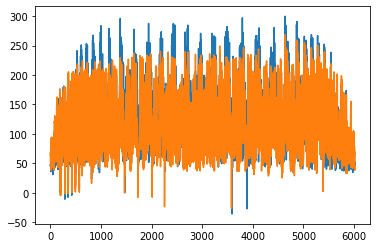

In [171]:
plt.plot(tsnr_data[diff_mask][:, np.random.choice(filtered_df.query('Scanner=="old"').index, 10, False)].mean(1))
plt.plot(tsnr_data[diff_mask][:, filtered_df.query('Scanner=="new"').index].mean(1))

In [179]:
tsnr_data.mean(1)

(33018,)

In [185]:
old = tsnr_data[diff_mask][:, np.random.choice(filtered_df.query('Scanner=="old"').index, 10, False)].mean(1)

In [186]:
new = tsnr_data[diff_mask][:, filtered_df.query('Scanner=="new"').index].mean(1)

In [198]:
diff_map = np.zeros(mask_nii.shape)
diff_map[diff_b_mask] = new-old

In [199]:
func_obj = nib.Nifti1Image(diff_map, mask_nii.affine, mask_nii.header)

In [214]:
diff_nii

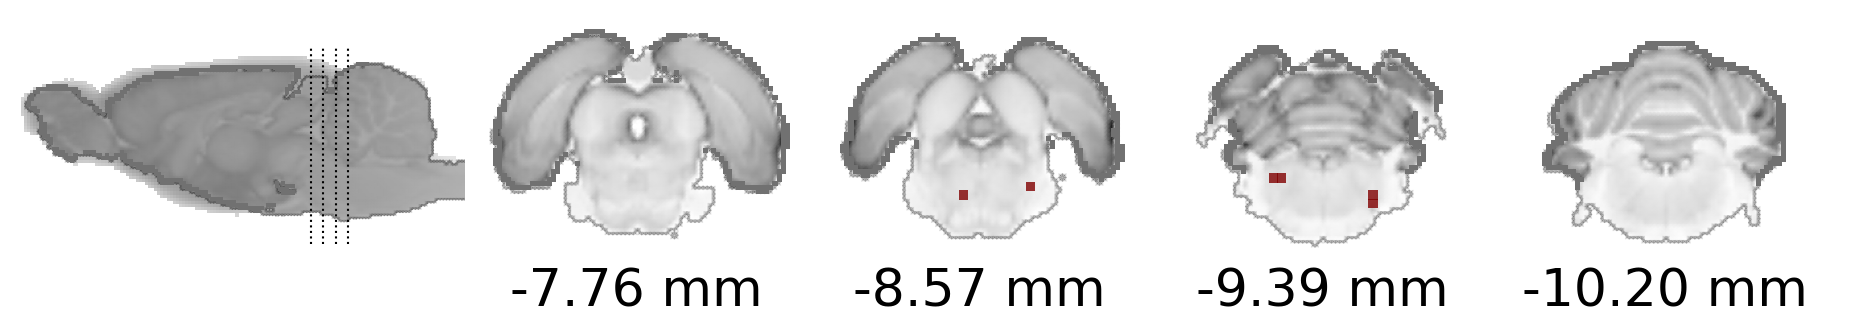

In [243]:
import numpy as np
from scipy.stats import norm
from custom_module import thr_by_voxelsize
crag = 10
alpha = 0.8

scaner_diff = './scanner_effect_perm.nii.gz'

func_obj = nib.load(scaner_diff)
func_obj = crop_by_voxel(pad_by_voxel(norm_orient(func_obj), a=1), l=15, r=15)
# func_obj = thr_by_z(func_obj, pval = 0.5)
func_obj = thr_by_voxelsize(func_obj, 100)
func_obj = correct_affine(func_obj)

slice_coords = np.linspace(10.9, -17.5, 36)[2:-2] # All slices coordinates
selected_coords = slice_coords[[21, 22, 23, 24]]
fig = mosaicview_paxinos(anat_obj, func_obj, selected_coords, dpi=300, 
                         navi=True, annotate=True, vmin=-crag, vmax=crag, alpha=alpha, 
                         fontsize=25, cmap='jet')

### ReHo

In [19]:
group_reho_path = oput_pm('GroupReHo-stats.nii.gz')
if os.path.exists(group_reho_path):
    reho_nii = nib.load(group_reho_path)
else:
    dcode_rsfmri = '41A'

    dset = pipe.get_dset(dcode_rsfmri)
    reho_data = None
    for i, finfo in tqdm(dset):
        reho_nii = nib.load(finfo.Abspath)
        if reho_data is None:
            reho_data = np.asarray(reho_nii.dataobj)[mask_idx]
        else:
            reho_data = np.c_[reho_data, np.asarray(reho_nii.dataobj)[mask_idx]]

    group_reho = onesample_ttest_perm(reho_data)

    reho_img = np.zeros(mask_nii.shape)
    reho_img[mask_idx] = group_reho[..., 0]

    reho_nii = nib.Nifti1Image(reho_img, mask_nii.affine)
    reho_nii.header['qform_code'] = 1
    reho_nii.header['sform_code'] = 0

    reho_nii.to_filename(group_reho_path)

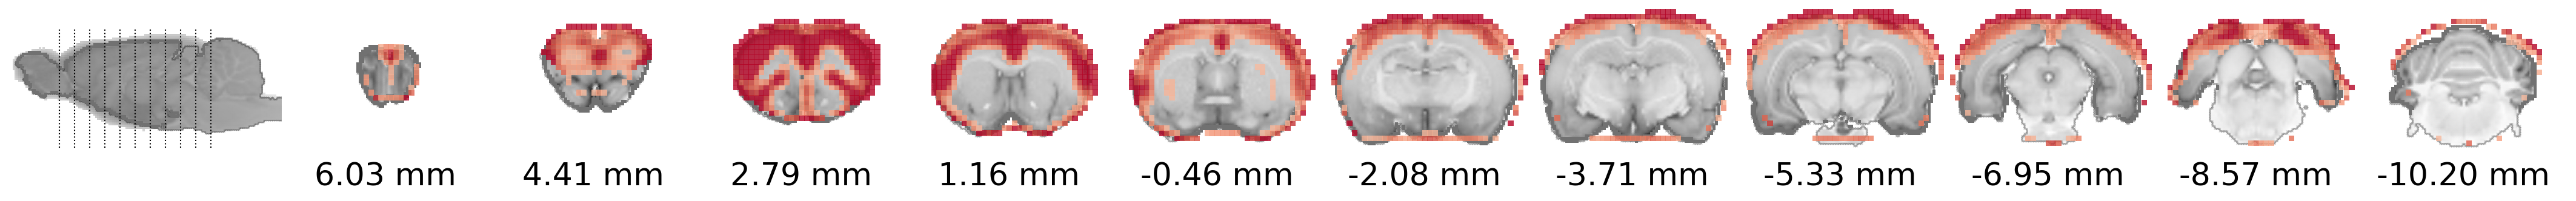

In [20]:
crag = 15
alpha = 0.8

func_obj = nib.load(group_reho_path)
func_obj = crop_by_voxel(pad_by_voxel(norm_orient(func_obj), a=1), l=15, r=15)
func_obj = thr_by_z(func_obj, pval = 0.5)
func_obj = correct_affine(func_obj)

slice_coords = np.linspace(10.9, -17.5, 36)[2:-2] # All slices coordinates
selected_coords = slice_coords[[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]]
fig = mosaicview_paxinos(anat_obj, func_obj, selected_coords, dpi=300, 
                         navi=True, annotate=True, vmin=-crag, vmax=crag, alpha=alpha, 
                         fontsize=25)

### ALFF

In [21]:
group_alff_path = oput_pm('GroupALFF-stats.nii.gz')
if os.path.exists(group_alff_path):
    alff_nii = nib.load(group_alff_path)
else:
    dcode_rsfmri = '22A'

    dset = pipe.get_dset(dcode_rsfmri)
    alff_data = None
    for i, finfo in tqdm(dset):
        alff_nii = nib.load(finfo.Abspath)
        if alff_data is None:
            alff_data = np.asarray(alff_nii.dataobj)[mask_idx]
        else:
            alff_data = np.c_[alff_data, np.asarray(alff_nii.dataobj)[mask_idx]]

    group_alff = onesample_ttest_perm(alff_data)

    alff_img = np.zeros(mask_nii.shape)
    alff_img[mask_idx] = group_alff[..., 0]

    alff_nii = nib.Nifti1Image(alff_img, mask_nii.affine)
    alff_nii.header['qform_code'] = 1
    alff_nii.header['sform_code'] = 0

    alff_nii.to_filename(group_alff_path)

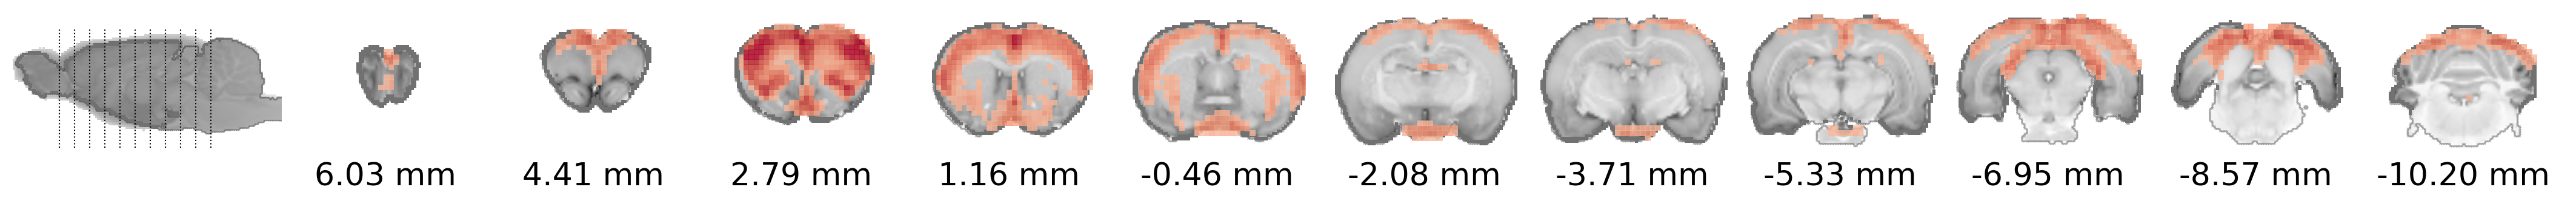

In [22]:
crag = 15
alpha = 0.8

func_obj = nib.load(group_alff_path)
func_obj = crop_by_voxel(pad_by_voxel(norm_orient(func_obj), a=1), l=15, r=15)
func_obj = thr_by_z(func_obj, pval = 0.5)
func_obj = correct_affine(func_obj)

slice_coords = np.linspace(10.9, -17.5, 36)[2:-2] # All slices coordinates
selected_coords = slice_coords[[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]]
fig = mosaicview_paxinos(anat_obj, func_obj, selected_coords, dpi=300, 
                         navi=True, annotate=True, vmin=-crag, vmax=crag, alpha=alpha, 
                         
                         fontsize=25)

### FC strencgh

In [23]:
group_fcst_path = oput_pm('GroupFCST-stats.nii.gz')
if os.path.exists(group_fcst_path):
    fcst_nii = nib.load(group_fcst_path)
else:
    dcode_rsfmri = '42A'

    dset = pipe.get_dset(dcode_rsfmri)
    fcst_data = None
    for i, finfo in tqdm(dset):
        fcst_nii = nib.load(finfo.Abspath)
        if fcst_data is None:
            fcst_data = np.asarray(fcst_nii.dataobj)[mask_idx]
        else:
            fcst_data = np.c_[fcst_data, np.asarray(fcst_nii.dataobj)[mask_idx]]
    group_fcst = onesample_ttest_perm(fcst_data)

    fcst_img = np.zeros(mask_nii.shape)
    fcst_img[mask_idx] = group_fcst[..., 0]

    fcst_nii = nib.Nifti1Image(fcst_img, mask_nii.affine)
    fcst_nii.header['qform_code'] = 1
    fcst_nii.header['sform_code'] = 0

    fcst_nii.to_filename(group_fcst_path)

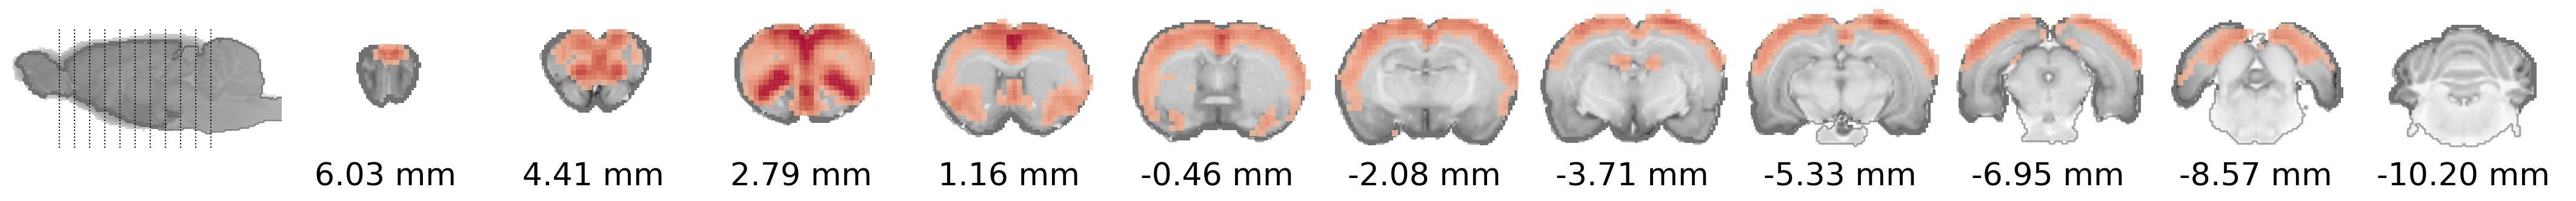

In [24]:
crag = 15
alpha = 0.8

func_obj = nib.load(group_fcst_path)
func_obj = crop_by_voxel(pad_by_voxel(norm_orient(func_obj), a=1), l=15, r=15)
func_obj = thr_by_z(func_obj, pval = 0.5)
func_obj = correct_affine(func_obj)

slice_coords = np.linspace(10.9, -17.5, 36)[2:-2] # All slices coordinates
selected_coords = slice_coords[[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]]
fig = mosaicview_paxinos(anat_obj, func_obj, selected_coords, dpi=300, 
                         navi=True, annotate=True, vmin=-crag, vmax=crag, alpha=alpha, 
                         fontsize=25)